In [12]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [13]:
jsons = {}
complaint_glob = r"D:\ig_pipeline\cad\*\*\complaints.json"
for fn in glob.glob(complaint_glob):
    fn = pathlib.Path(fn)
    with open(fn, "r") as f:
        jsons["/".join(fn.parts[-3:-1])] = json.load(f)

In [14]:
print(jsons.keys())

dict_keys(['objects/batch-00', 'objects/batch-01', 'objects/batch-02', 'objects/batch-03', 'objects/batch-04', 'objects/batch-05', 'objects/batch-06', 'objects/batch-07', 'objects/batch-08', 'objects/batch-09', 'objects/batch-10', 'objects/batch-11', 'objects/batch-12', 'objects/batch-13', 'objects/custom-aa', 'objects/legacy_batch-00', 'objects/legacy_batch-01', 'objects/legacy_batch-02', 'objects/legacy_batch-03', 'objects/legacy_batch-04', 'objects/legacy_batch-05', 'objects/legacy_batch-06', 'objects/legacy_batch-07', 'objects/legacy_batch-08', 'objects/legacy_batch-09', 'objects/legacy_batch-10', 'objects/legacy_batch-11', 'objects/legacy_batch-12', 'objects/procedural-aa', 'objects/school_objects-aa', 'objects/substances-02', 'objects/task_relavant-ab', 'objects/task_relevant-xy', 'scenes/Beechwood_0_garden', 'scenes/Beechwood_0_int', 'scenes/Beechwood_1_int', 'scenes/Benevolence_0_int', 'scenes/Benevolence_1_int', 'scenes/Benevolence_2_int', 'scenes/commercial_kitchen_fire_extin

In [15]:
next(iter(jsons.values()))

[{'object': 'batting_gloves-uteyjv',
  'complaint': 'x5',
  'processed': True,
  'type': 'scale',
  'additional_info': "Confirm reasonable bounding box size:\n1.26m, 70.25cm, 56.99cm\nMake sure these sizes are within the same order of magnitude you expect from this object IRL.\nIf the scale is off, please let us know by a factor of how much (for example, 1000 if something\nthat's supposed to be 1mm is 1m instead) in your complaint note."},
 {'object': 'batting_gloves-uteyjv',
  'complaint': 'quick complaint added during qa-2025 batch qa-2025-eric',
  'processed': False,
  'new': True,
  'type': 'collision',
  'additional_info': ''},
 {'object': 'bottle_of_deicer-xepoez',
  'complaint': 'bad center of mass, will always tip over',
  'processed': True,
  'new': True,
  'type': 'appearance',
  'additional_info': 'APPEARANCE: Confirm object visual appearance.\nRequirements:\n- make sure the object has a valid texture or appearance (e.g., texture not black,\n       transparency rendered corr

In [16]:
import collections
import re

complaints_by_type = collections.defaultdict(list)
complained_objects_by_type = collections.defaultdict(set)

for j in jsons.values():
    for complaint in j:
        if complaint["processed"]:
            continue
            
        complaint_type = complaint["type"]
        complaints_by_type[complaint_type].append(complaint)
        complained_objects_by_type[complaint_type].add(complaint["object"].split("-")[-1])

In [17]:
print(complaints_by_type.keys())

dict_keys(['collision', 'category', 'appearance', 'metalink', 'clothappearance', 'handle', 'unknown', 'centerofmass', 'joint', 'substanceness', 'scale', 'softbody', 'connectedness', 'structureconnectedness', 'structureunclosed', 'structurethickness'])


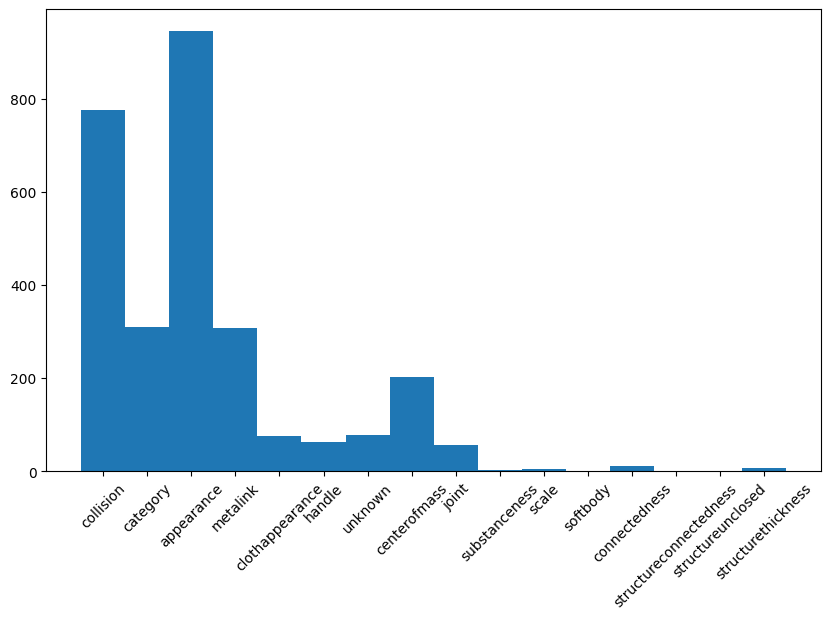

In [18]:
plt.rcParams["figure.figsize"] = (10,6)
labels, values = zip(*[(k, len(v)) for k, v in complaints_by_type.items()])

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=45)
plt.show()

In [8]:
from bddl.knowledge_base import *

Loading BDDL knowledge base... This may take a few seconds.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cgokmen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Complained object azqqwx does not exist in the database. Skipping.
Complained object ntmrkt does not exist in the database. Skipping.


In [9]:
appearance_complaint_objects = complained_objects_by_type["appearance"]
cloth_appearance_complaint_objects = {o for o in appearance_complaint_objects if any(p.name == "cloth" for p in Object.get(o).category.synset.properties)}
noncloth_appearance_complaint_objects = appearance_complaint_objects - cloth_appearance_complaint_objects

In [10]:
# Load the bad material objects
with open("bad_materials.json", "r") as f:
    bad_materials = set(json.load(f))

print("Objects that are complained about for appearance and are cloth (excluded from below math):", len(cloth_appearance_complaint_objects))
print("Objects that are complained about for appearance:", len(noncloth_appearance_complaint_objects))
print("Objects that have non-Vray materials:", len(bad_materials))
print("Objects that are complained about for appearance and have non-Vray materials:", len(noncloth_appearance_complaint_objects & bad_materials))
print("Objects that have non-Vray material but not complained about for appearance:", len(bad_materials - noncloth_appearance_complaint_objects))
print("Objects that are complained about for appearance but have good materials:", len(noncloth_appearance_complaint_objects - bad_materials))

Objects that are complained about for appearance and are cloth (excluded from below math): 70
Objects that are complained about for appearance: 833
Objects that have non-Vray materials: 1394
Objects that are complained about for appearance and have non-Vray materials: 291
Objects that have non-Vray material but not complained about for appearance: 1103
Objects that are complained about for appearance but have good materials: 542


In [11]:
for fn in glob.glob(complaint_glob):
    with open(fn, "r") as f:
        complaints_in_file = json.load(f)
    for c in complaints_in_file:
        if c["type"] == "appearance" and not c["processed"] and c["object"].split("-")[-1] in cloth_appearance_complaint_objects:
            c["type"] = "clothappearance"
    with open(fn, "w") as f:
        json.dump(complaints_in_file, f, indent=4)